# Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from time_series_functions import(
    create_lstm_dataset,
    split_time_series
)

In [2]:
import tensorflow as tf
import os

# Get the ZIP file and extract it
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

# Extracted directory
extracted_dir = os.path.dirname(zip_path)
print("Extracted directory:", extracted_dir)

# List files in the extracted directory
extracted_files = os.listdir(extracted_dir)
print("Files in extracted directory:", extracted_files)


Extracted directory: C:\Users\Connor\.keras\datasets
Files in extracted directory: ['cifar-10-batches-py', 'cifar-10-batches-py.tar.gz', 'eval.csv', 'fashion-mnist', 'flower_photos', 'flower_photos.tar.gz', 'ImageNetLabels.txt', 'jena_climate_2009_2016.csv.zip', 'jena_climate_2009_2016_extracted', 'train.csv']


In [3]:
csv_file_path = os.path.join(extracted_dir, 'jena_climate_2009_2016_extracted', 'jena_climate_2009_2016.csv')

# Verify the path
print("CSV File Path:", csv_file_path)


CSV File Path: C:\Users\Connor\.keras\datasets\jena_climate_2009_2016_extracted\jena_climate_2009_2016.csv


In [4]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


<Axes: >

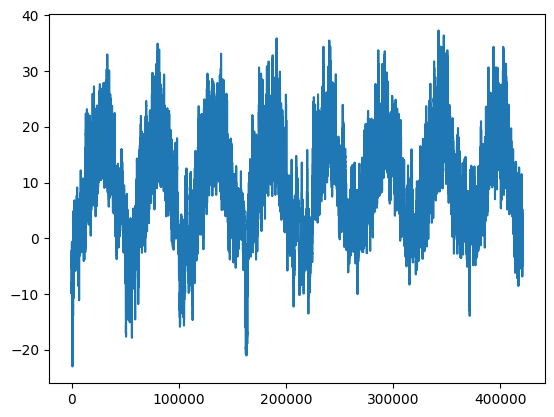

In [5]:
temp = df['T (degC)']
temp.plot()

# Time Series Forecasting - Univariate

### convert Date Time col to datetime and set index

In [6]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### split dataset in to train, val, and test partitions

In [7]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import MinMaxScaler


# Simulated time-series data
data = df['T (degC)']

In [8]:
X, y = create_lstm_dataset(data, lookback=5)

In [10]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_time_series(X, y, train_frac=0.7, val_frac=0.15)

print("Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

 ## LSTM

In [14]:
model_lstm = Sequential()
model_lstm.add(InputLayer((5, 1)))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(8, 'relu'))
model_lstm.add(Dense(1, 'linear'))

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpoint_lstm = ModelCheckpoint(
    'model_lstm/model_checkpoint.keras', 
    save_best_only=True
)

model_lstm.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError()]
)

In [16]:
model_lstm.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    callbacks=[checkpoint_lstm]
)

Epoch 1/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0193 - root_mean_squared_error: 0.1143 - val_loss: 1.0528e-04 - val_root_mean_squared_error: 0.0103
Epoch 2/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 9.4347e-05 - root_mean_squared_error: 0.0097 - val_loss: 6.6968e-05 - val_root_mean_squared_error: 0.0082
Epoch 3/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 5.3217e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.5645e-05 - val_root_mean_squared_error: 0.0051
Epoch 4/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 2.6121e-05 - root_mean_squared_error: 0.0051 - val_loss: 2.5456e-05 - val_root_mean_squared_error: 0.0050
Epoch 5/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2.2958e-05 - root_mean_squared_error: 0.0048 - val_loss: 1.9861e-05 - val_root_mean_squared_error: 0.0045
Epoch 6/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2.1142e-05 - root_mean_squared_error: 0.0046 - val_loss: 2.4022e-05 - val_root_mean_squared_erro

In [25]:
model_lstm = load_model('model_lstm/model_checkpoint.keras')

In [27]:
train_predictions = model_lstm.predict(X_train).flatten()

9200/9200 ━━━━━━━━━━━━━━━━━━━━ 7s 801us/step


In [29]:
train_results = pd.DataFrame(
    data={
        'Train Predictions': train_predictions,
         'Actuals': y_train.flatten(),
         }
)
train_results

,Train Predictions,Actuals
0,0.244104,0.248134
1,0.248231,0.255266
2,0.255650,0.255266
3,0.256626,0.250456
4,0.251632,0.241831
...,...,...
294377,0.622310,0.620169
294378,0.619533,0.621496
294379,0.621447,0.619174
294380,0.619218,0.615525


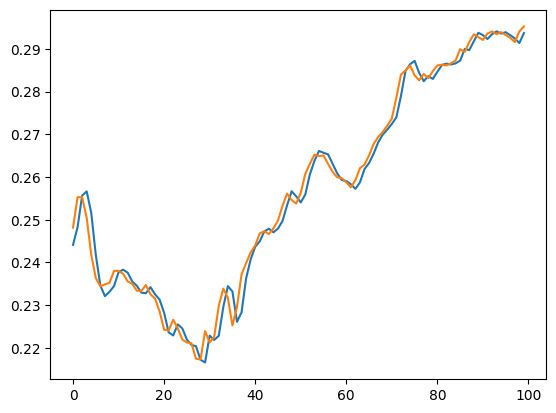

In [30]:
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])

### Predict validation results

In [31]:
val_predictions = model_lstm.predict(X_val).flatten()

1972/1972 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step


In [32]:
val_results = pd.DataFrame(
    data={
        'Validation Predictions': val_predictions,
         'Actuals': y_val.flatten(),
         }
)
val_results

,Validation Predictions,Actuals
0,0.612610,0.609720
1,0.608579,0.608890
2,0.608118,0.611047
3,0.611291,0.610881
4,0.611546,0.609388
...,...,...
63076,0.491215,0.491624
63077,0.491897,0.491956
63078,0.492459,0.491126
63079,0.491606,0.491790


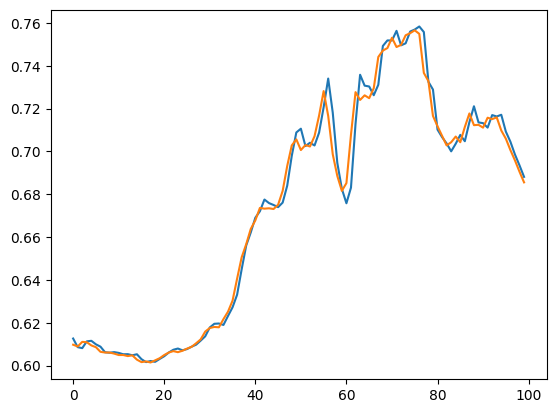

In [33]:
plt.plot(val_results['Validation Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

### Predicting Test Results

In [34]:
test_predictions = model_lstm.predict(X_test).flatten()

1972/1972 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step


In [35]:
test_results = pd.DataFrame(
    data={
        'Test Predictions': test_predictions,
         'Actuals': y_test.flatten(),
         }
)
test_results

,Test Predictions,Actuals
0,0.490607,0.490794
1,0.491075,0.489965
2,0.490257,0.490629
3,0.490989,0.490297
4,0.490761,0.488970
...,...,...
63078,0.317677,0.314480
63079,0.315128,0.326091
63080,0.325898,0.329242
63081,0.330691,0.311494


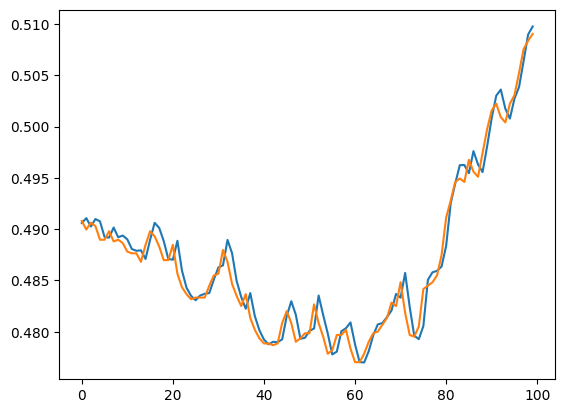

In [36]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

## CNN